# How to use this notebook:

At first, there will be a lot of code cluttering things up. To hide of the code, at the top of the page click Kernal --> Restart and Run All. This will run the program and now you will have the ability to toggle on/off the raw code.

In [1]:
import numpy as np
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import math
from scipy import stats
import glob
from scipy.interpolate import interp1d
import mplcursors
%matplotlib inline
from matplotlib.widgets import Slider, Button, RadioButtons
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import HTML, display
import IPython
from astropy import constants as const
from astropy import units as u

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
ML_disk, ML_bulge, DM_frac, SB_bary, Ltot, HImass, Vflat, index_stop = np.loadtxt('data for good galaxies.csv', delimiter=',', skiprows = 1, usecols = (1,2,3,5,14,20,22,24),unpack = True)
Lbulge  = np.loadtxt('sparc global measurements.csv', delimiter=',', unpack = True, skiprows = 2, usecols = (20)) 
sparc = np.load('sparc_dict.npy').item()
name = np.loadtxt('starkman data.csv', delimiter=',', skiprows = 2, usecols = (0), dtype = 'object', unpack = True)
Mbary = np.loadtxt('starkman data.csv', delimiter=',', skiprows = 2, usecols = (19), unpack = True)
rad_start, rad_stop = np.loadtxt('bracketing curves.csv', delimiter=',', skiprows = 1, usecols = (3,4),unpack = True)

Ltot, Lbulge, HImass , Mbary = Ltot*1e9, Lbulge*1e9, HImass*1e9, Mbary*1e9


In [3]:
len_tot = 116
Rp_arr = np.empty(len_tot) #stores Rp
DM_frac = np.empty(len_tot) #stores fraction of galaxies which are DM by mass
SB_bary = np.empty(len_tot) #stores baryonic surface brightness
Mbary_arr  = np.empty(len_tot) #stores baryonic mass of galaxy
ML_disk  = np.full(len_tot, 0.5)
ML_bulge  = np.full(len_tot, 0.7)
Vp_baryarr = np.empty(len_tot) #stores Vp of baryonic rotation curve
Vp_obsarr = np.empty(len_tot) #stores Vp of observed rotation curve
index_stoparr = np.empty(len_tot) #stores the array index of Rp
index_peakarr = np.empty(len_tot) #stores the array index of the upper bracket for finding Rp

M_new =np.empty(len_tot)


In [18]:
def interpolation(gal_name, mult_factor, start, stop):
    ML_disknew, ML_bulgenew = 0.5*mult_factor, 0.7*mult_factor
   
    vbary = np.sqrt(ML_disknew * sparc[gal_name+"_Vdisk"]**2 + ML_bulgenew * sparc[gal_name+"_Vbul"]**2 + sparc[gal_name+"_Vgas"]**2 )
    vbary_orig = np.sqrt(0.5 * sparc[gal_name+"_Vdisk"]**2 + 0.7 * sparc[gal_name+"_Vbul"]**2 + sparc[gal_name+"_Vgas"]**2 )

    interp_vobs = interp.UnivariateSpline(sparc[gal_name+"_rad"], sparc[gal_name+'_Vobs']) #interpolating points in Vobs
    radius_vals = np.linspace(sparc[gal_name+"_rad"].min(), sparc[gal_name+"_rad"].max(), 1000) #creating radius values for interpolation
    interp_vbary = interp.UnivariateSpline(sparc[gal_name+"_rad"], vbary) #interpolating points in Vbary
    interp_vbary_orig = interp.UnivariateSpline(sparc[gal_name+"_rad"], vbary_orig) #interpolating points in Vbary with original M/L
    
    #bracketing:
    index_start =np.argmin(np.abs(start - radius_vals)) #minimum bracket index
    index_stop = np.argmin(np.abs(stop - radius_vals))#maximum bracket index
    #interp_vbaryderiv = interp_vbary(radius_vals, nu=1)
    index_peak = index_start + np.argmax(interp_vbary(radius_vals)[index_start:index_stop]) #gets Vpeak by finding max velocity in Vbary interpolation
    
    Rp = radius_vals[index_peak] #Rp is the radius corresponding to peak index
    Rp_arr[sparc[gal_name+"_index"]] = Rp
    Vp_bary = interp_vbary(Rp) #putting Rp in interpolation to find Vbary at Rp
    Vp_obs = interp_vobs(Rp) #putting Rp in interpolation to find Vobs at Rp
    
    DM_frac[sparc[gal_name+"_index"]] = (Vp_obs - Vp_bary)/Vp_obs #gives fraction of galaxy that contains dark matter
    SB_bary[sparc[gal_name+"_index"]]  = (3/4) * (Mbary_arr[sparc[gal_name+"_index"]]/Rp**2) #baryonic surface brightness
    Vp_baryarr[sparc[gal_name+"_index"]] = Vp_bary #just adding Vp,bary to array for use outside function
    Vp_obsarr[sparc[gal_name+"_index"]] = Vp_obs
    index_peakarr[sparc[gal_name+"_index"]] = index_peak
    index_stoparr[sparc[gal_name+"_index"]] = index_stop
    
    Mgas = HImass[sparc[gal_name+"_index"]]
    Mbulgenew = Lbulge[sparc[gal_name+"_index"]] * ML_bulgenew  
    Mbulgeold = Lbulge[sparc[gal_name+"_index"]] * .7
    Mdisknew = (Ltot[sparc[gal_name+"_index"]] - Lbulge[sparc[gal_name+"_index"]]) * ML_disknew
    

    M_new[sparc[gal_name+"_index"]] = Mdisknew + Mbulgenew +Mgas#luminosity with new M/L        
    return Mgas, Mbulgenew, Mdisknew

Below, `mult_factor` represents the factor by which the mass to light ratios of the bulge and disk (initially set at 0.7 and 0.5, respectively) are multiplied. For example, setting the slider value to 2 would set $\Upsilon_{bulge}=1.4, \Upsilon_{disk}=1$. The diagonal dashed line represents a dlog(V)/dlog(R) of -0.5, which was predicted in [Courteau & Rix (1999)](https://iopscience.iop.org/article/10.1086/306872/meta). However, as playing with the slider shows, the slope doesn't reach nearly that level of steepness.

A note about how the mass is calculated with changes in M/L: $\mathrm{M_{bary} = M_{bulge} + M_{gas} + M_{disk}}$ where 
- $\mathrm{M_{bulge} = L_{bulge} * \Upsilon_{bulge, new}}$
- $\mathrm{M_{gas}}$ is given as the mass of HI gas
- $\mathrm{M_{disk} = (L_{tot} - L_{bulge})*\Upsilon_{disk, new}}$

In [19]:
def other_plots():

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))


    print('modified M/L = original M/L * mult_factor')

    goodvals = np.where((Vp_obsarr > Vp_baryarr) & (index_peakarr < index_stoparr) & (M_new > 0))
    
    ##Vobs
    ax1.scatter(np.log10(Mbary[goodvals]), np.log10(Vp_obsarr[goodvals]),alpha=0.5, label = 'original M/L')
    ax1.scatter(np.log10(M_new[goodvals]), np.log10(Vp_obsarr[goodvals]), alpha=0.5, label = ('M/L * mult_factor'))
    ax1.set_xlabel('log(M) [Msun]', fontsize = 'large')
    ax1.set_ylabel('log(Vobs) [km/s]', fontsize = 'large')
    ax1.legend()

    coeff,cov=np.polyfit(np.log10(Mbary[goodvals]), np.log10(Vp_obsarr[goodvals]),1,cov=True) #creating best-fit line from original data
    coeff_err = np.sqrt(np.diag(cov))
    xfit=np.linspace(min(np.log10(Mbary)),max(np.log10(Mbary)),1000)
    polynomial=np.poly1d(coeff)
    ax1.plot(xfit,polynomial(xfit),color='blue', alpha=.5)
    print(' \n  with original M/L: dV/dM = {:.3f} +/- {:.3f}'.format(coeff[0],coeff_err[0]))
    
    coeff,cov=np.polyfit(np.log10(M_new[goodvals]), np.log10(Vp_obsarr[goodvals]),1,cov=True) #creating best-fit line from modified data
    coeff_err = np.sqrt(np.diag(cov))
    xfit=np.linspace(min(np.log10(Mbary)),max(np.log10(Mbary)),1000)
    polynomial=np.poly1d(coeff)
    ax1.plot(xfit,polynomial(xfit),color='orange')
    print('  with modified M/L: dV/dM = {:.3f} +/- {:.3f}'.format(coeff[0],coeff_err[0]))

    delt_Vnew = np.log10(Vp_obsarr[goodvals]) - (coeff[0]*np.log10(M_new[goodvals]) + coeff[1]) #delt_v = Vp_obs - (mx+b) where m,b solved in best fit line

    ## Rp
    ax2.scatter(np.log10(Mbary[goodvals]), np.log10(Rp_arr[goodvals]),alpha=0.5, label = 'original M/L')
    ax2.scatter(np.log10(M_new[goodvals]), np.log10(Rp_arr[goodvals]), alpha=0.5,label = ('M/L * mult_factor'))
    ax2.set_xlabel('log(M) [Msun]', fontsize = 'large')
    ax2.set_ylabel('log(Rp) [kpc]', fontsize = 'large')
    ax2.legend()

    coeff,cov=np.polyfit(np.log10(Mbary[goodvals]), np.log10(Rp_arr[goodvals]),1,cov=True) #creating best-fit line from original data
    coeff_err = np.sqrt(np.diag(cov))
    xfit=np.linspace(min(np.log10(Mbary)),max(np.log10(Mbary)),1000)
    polynomial=np.poly1d(coeff)
    ax2.plot(xfit,polynomial(xfit),color='blue', alpha=.5)
    print(' \n  with original M/L: dR/dM = {:.3f} +/- {:.3f}'.format(coeff[0],coeff_err[0]))

    coeff,cov=np.polyfit(np.log10(M_new[goodvals]), np.log10(Rp_arr[goodvals]),1,cov=True) #creating best-fit line from modified data
    coeff_err = np.sqrt(np.diag(cov))
    xfit=np.linspace(min(np.log10(Mbary)),max(np.log10(Mbary)),1000)
    polynomial=np.poly1d(coeff)
    ax2.plot(xfit,polynomial(xfit),color='orange')
    print('  with modified M/L: dR/dM = {:.3f} +/- {:.3f}'.format(coeff[0],coeff_err[0]))
    #print(delt_Vnew, delt_Rnew)

    delt_Rnew = np.log10(Rp_arr[goodvals]) - (coeff[0]*np.log10(Mbary[goodvals]) + coeff[1])


In [28]:
def ML_linear(mult_factor, colorbar):
    ML_disknew = 0.5 * mult_factor
    ML_bulgenew = 0.7 * mult_factor

    goodvals = np.where((Vp_obsarr > Vp_baryarr) & (index_peakarr < index_stoparr) & (M_new > 0))
    
    ##Vobs
    coeff,cov=np.polyfit(np.log10(M_new[goodvals]), np.log10(Vp_obsarr[goodvals]),1,cov=True) #creating best-fit line from modified data
    coeff_err = np.sqrt(np.diag(cov))
    xfit=np.linspace(min(np.log10(Mbary)),max(np.log10(Mbary)),1000)
    polynomial=np.poly1d(coeff)

    delt_Vnew = np.log10(Vp_obsarr[goodvals]) - (coeff[0]*np.log10(M_new[goodvals]) + coeff[1]) #delt_v = Vp_obs - (mx+b) where m,b solved in best fit line

    ## Rp
    coeff,cov=np.polyfit(np.log10(M_new[goodvals]), np.log10(Rp_arr[goodvals]),1,cov=True) #creating best-fit line from modified data
    coeff_err = np.sqrt(np.diag(cov))
    xfit=np.linspace(min(np.log10(Mbary)),max(np.log10(Mbary)),1000)
    polynomial=np.poly1d(coeff)

    delt_Rnew = np.log10(Rp_arr[goodvals]) - (coeff[0]*np.log10(M_new[goodvals]) + coeff[1])
    
    
    plt.figure(figsize=(10,8))
    
    #goodvals = np.where((Vp_obsarr > Vp_baryarr) & (index_peakarr < index_stoparr))
    if (colorbar == "mass"):
        plt.scatter(delt_Rnew, delt_Vnew, c =np.log10(M_new[goodvals]), cmap=plt.cm.get_cmap('plasma_r'))
        plt.colorbar().set_label("log(Mbary)")
    elif (colorbar == "DM fraction"):
        plt.scatter(delt_Rnew, delt_Vnew, c =DM_frac[goodvals], cmap=plt.cm.get_cmap('plasma_r'))
        plt.colorbar().set_label("% dark matter")
    else:
        plt.scatter(delt_Rnew, delt_Vnew, c =Vp_baryarr[goodvals]/Vp_obsarr[goodvals], cmap=plt.cm.get_cmap('plasma_r'))
        plt.colorbar().set_label("Vp,bary / Vp,obs")
    plt.axis('equal')
    plt.xlabel('d log(Rp)', fontsize = 'large')
    plt.ylabel('d log(V)', fontsize = 'large')

    coeff,cov=np.polyfit(delt_Rnew, delt_Vnew,1,cov=True)
    coeff_err = np.sqrt(np.diag(cov))
    xfit=np.linspace(min(delt_Rnew),max(delt_Rnew),1000)
    polynomial=np.poly1d(coeff)
    plt.plot(xfit,polynomial(xfit),color='green')
    print('    slope = {:.6f} +/- {:.3f}'.format(coeff[0],coeff_err[0]))

    plt.plot(xfit, xfit*-.5, ls = ':')
    plt.axhline(ls = ':')
    
    return coeff[0],coeff_err[0]
                                                                              
                                                                              

In [30]:
def dVdR(mult_factor, colorbar):
    for x in range(len(name)):
        interpolation(name[x], mult_factor, rad_start[x], rad_stop[x])
    slope, slope_err= ML_linear(mult_factor, colorbar)
    return slope, slope_err

interact(dVdR, mult_factor=widgets.FloatSlider(value=1, min=0.01, max=5,step=0.01, continuous_update=False), colorbar=["Mbary", "DM fraction", "Vp,bary / Vp,obs"]) 


interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='mult_factor', max=5.0, min=…

<function __main__.dVdR(mult_factor, colorbar)>

The graphs below provide a little more insight into the graph above. On the left, I have graphed V vs M (Tully-Fisher) using both the original and new M/L, and fitted best-fit lines for each. The same is done on the right, except with Rp vs M. The dlog(V) and dlog(R) values above are found by calculating the distance between the velocity of a point and the velocity of its corresponding place on the best-fit line, keeping the same luminosity value. 

Although the above graph updates automatically with changing M/L, you must click the "press to reload" button to update the graphs below. 

modified M/L = original M/L * mult_factor
 
  with original M/L: dV/dM = 0.290 +/- 0.007
  with modified M/L: dV/dM = 0.351 +/- 0.018
 
  with original M/L: dR/dM = 0.180 +/- 0.029
  with modified M/L: dR/dM = 0.262 +/- 0.038


Button(description='press to reload', style=ButtonStyle())

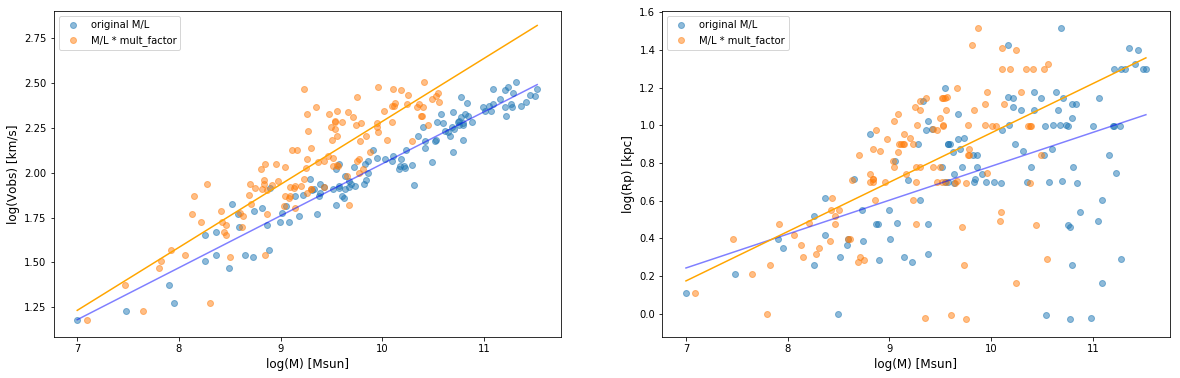

In [8]:
def on_button_clicked(b):
    IPython.display.clear_output()
    other_plots()
    display(button)

button = widgets.Button(description="press to reload")
display(button)
button.on_click(on_button_clicked)